In [49]:
!pip install opencv-python -q

In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset
import torchvision.transforms.functional as TF # Loading image , not only tensor 
from torchvision.io import read_image
from torchvision import transforms

import cv2
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image



## Loading Dataset

In [2]:
train_set = r"/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/training_set"
test_set = r"/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/test_set"
test_csv = r"/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/test_set_pixel_size.csv"
train_csv = r"/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/training_set_pixel_size_and_HC.csv"

## Config Training 

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Image size padding

torch.Size([1, 812, 812])


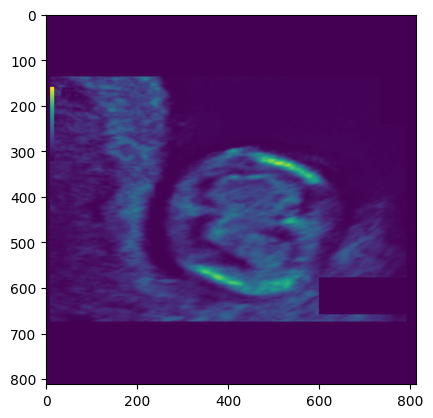

In [5]:
def pad_image_to_square(img):


  channels, height, width = img.size()
  diff = abs(812-width)
  # Determine the amount of padding to add on each side
  padding = diff // 2
  
  # to make it 812*812
  img = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)
  # print(img.shape)
  
  # print("hey" , img.size())

  channels, height, width = img.size()
  diff = abs(height-width)
  # Determine the amount of padding to add on each side
  padding = diff // 2


  # Pad the tensor with zeros along the height and width dimensions
  if height < width:
      padded_image = torch.nn.functional.pad(img, (0, 0, padding, diff - padding), mode='constant', value=0)
  else:
      padded_image = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)


  return padded_image


# Open the rectangular image
img = read_image(r'/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/test_set/001_HC.png')


# Pad the image to make it square
padded_img = pad_image_to_square(img)
print(padded_img.shape)

tensor_image = padded_img.permute(1, 2, 0)
plt.imshow(tensor_image)
plt.show()

## Data Loader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform , target_transform):
        self.img_path = img_path
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img = pad_image_to_square(img)

        if self.target_path:
          img_path_tar = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])

          target = cv2.imread(img_path_tar , 0)
          mask_contour= cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(target,mask_contour[0],0,255, -1)
          target = target[np.newaxis, :, :]
          target = torch.from_numpy(target)
          target = pad_image_to_square(target)
        else :
          target = torch.tensor([])
          

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            # print("target", target.shape, type(target))
            target = self.target_transform(target)
            target = torch.where(target > 128, torch.tensor([1.0]), torch.tensor([0.0]))

        return img.float(), target.float()



# Define the transformation to resize the images to 64x64 pixels
transform = transforms.Compose([
    transforms.Resize((252, 252))   # 572 , 572
    # transforms.ToTensor()
])

transform1 = transforms.Compose([
    transforms.Resize((68, 68))   # 388 , 388'

])
# Instantiate dataset object
dataset = CustomDataset(

    img_path = R'/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/training_set/images' ,
    target_path = R'/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/training_set/annotations' ,
    transform=transform , 
    target_transform = transform1 )

test_dataset = CustomDataset(
    img_path = R'/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/test_set' ,
    target_path = None ,
    transform=transform , 
    target_transform = None
    )

# justto check number of images
img_path = r'/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/training_set/images'
print(len(os.listdir(img_path)))
target_path = r'/Users/nguyenthanhvinh/Documents/USTH/ml_med/mlmed2026_Vinh/practice_2/practice_2/data/test_set'
print(len(os.listdir(target_path)))


import torch.utils.data as data
train_dataset, val_dataset = data.random_split(dataset, [799, 200])


# Create train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True) #,worker_init_fn=lambda _: random.seed(42))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))



999
335


## Preview image

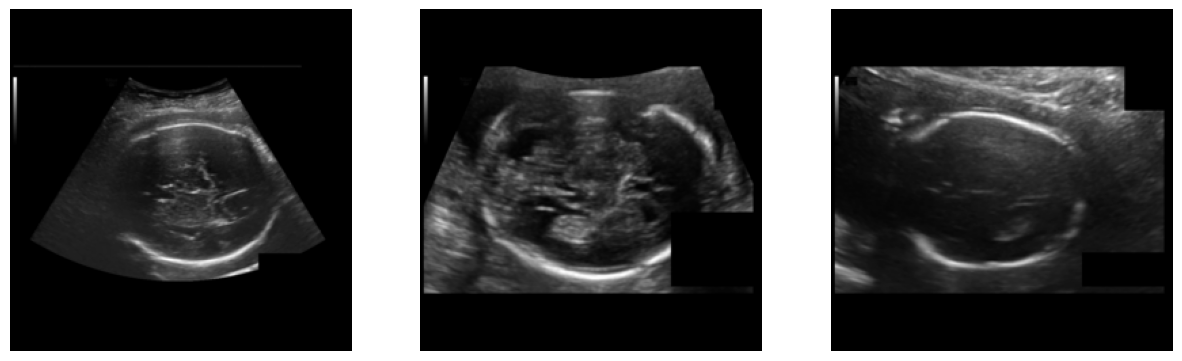

In [17]:
import itertools
i = 0
for i, batch in enumerate(train_dataloader):
  if i == 1:
      break
  # print(f"Batch {i+1}: {batch}")

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
  for i in range(3):
      axs[i].imshow(batch[0][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1

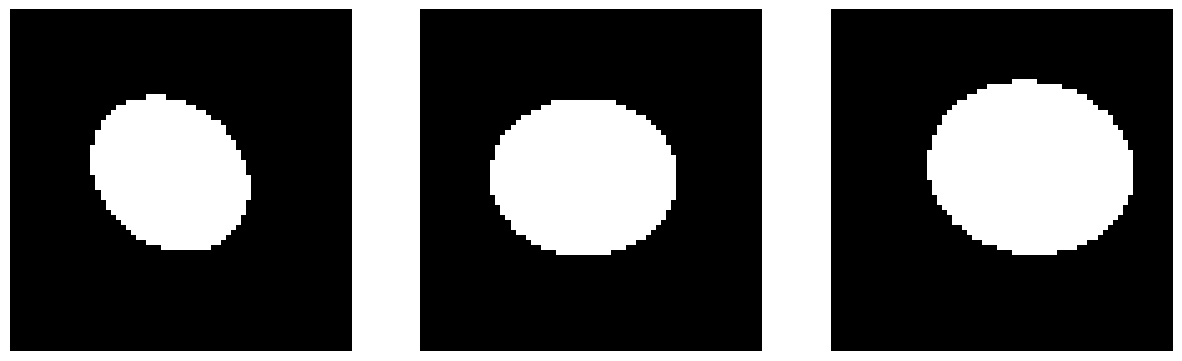

In [72]:
import matplotlib.pyplot as plt
import torch
i = 0
import itertools
for i, batch in enumerate(train_dataloader):
  if i == 1:
      break
  # print(f"Batch {i+1}: {batch}")

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
  for i in range(3):
      axs[i].imshow(batch[1][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1

## Why we choose U-net?
- U-Net is the CNN architect which specified made for segmentation task 
- Medical image require pixel-level precise level, not like detect with bounding box 

## Conv Architecture (Unet)
- Unet has specific part in its architectecture call 'Dual Convolution Block' 

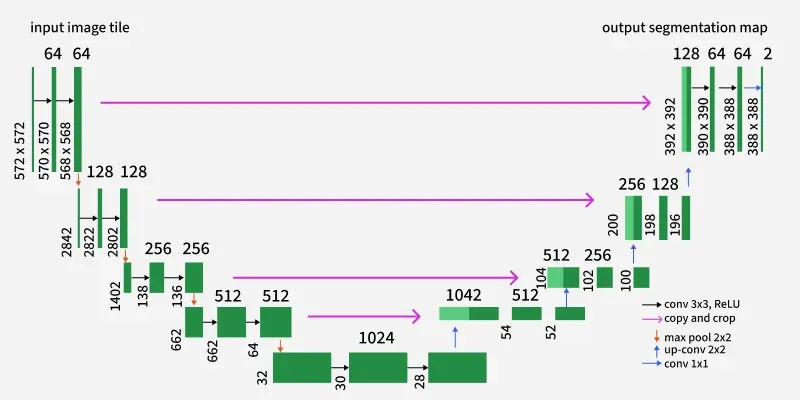

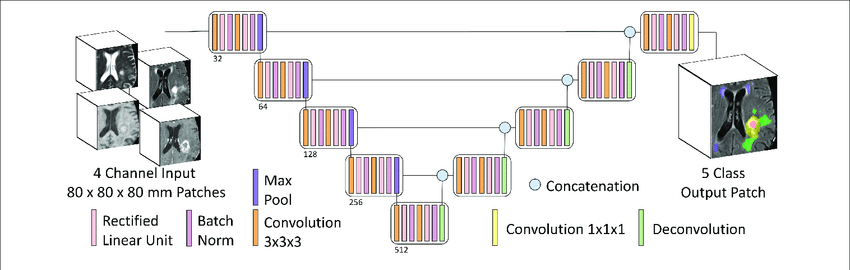

In [18]:
import torch.nn as nn
import torch.nn.functional as F


def scale_tensor(image ,new_height , new_width):
  scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
  return scaled_image


#double 3x3 convolution 
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
    )
    return conv


# crop the image(tensor) to equal size 
# as shown in architecture image , half left side image is concated with right side image
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2

    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

def out_layer(in_channel , out_channel):
  conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1),
      nn.BatchNorm2d(out_channel),
      nn.Sigmoid()
  )
  return conv_layer

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        # Left side (contracting path)
        self.dwn_conv1 = dual_conv(1, 64)
        self.dwn_conv2 = dual_conv(64, 128)
        self.dwn_conv3 = dual_conv(128, 256)
        self.dwn_conv4 = dual_conv(256, 512)
        self.dwn_conv5 = dual_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Right side  (expnsion path) 
        #transpose convolution is used showna as green arrow in architecture image
        self.conv_bn=nn.BatchNorm2d(1024)

        self.trans1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride= 2)
        self.up_conv1 = dual_conv(1024,512)
        self.trans2 = nn.ConvTranspose2d(512,256, kernel_size=2, stride= 2)
        self.up_conv2 = dual_conv(512,256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride= 2)
        self.up_conv3 = dual_conv(256,128)
        self.trans4 = nn.ConvTranspose2d(128,64, kernel_size=2, stride= 2)
        self.up_conv4 = dual_conv(128,64)

     
        self.out = out_layer(64 , 1)

    def forward(self, image):

        
        x1 = self.dwn_conv1(image)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)
        

        #forward pass for Right side
        x_norm = self.conv_bn(x9)
        x = self.trans1(x_norm)
        y = crop_tensor(x, x7)
        # print(x.shape , y.shape)
        x = self.up_conv1(torch.cat([x,y], 1))

        x = self.trans2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.trans3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.trans4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv4(torch.cat([x,y], 1))
        
        x = self.out(x)

        
        return x




## Trainning UNet 

In [13]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

In [16]:
torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
# batch_size = 2
learning_rate = 0.001
num_epochs = 10



# Define the U-Net architecture
model = Unet()
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

v_loss , train_loss = [] , []
# Train the U-Net
for epoch in range(num_epochs):
  model.train()
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = 0
    for inputs, targets in val_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets)
    val_loss /= len(val_dataloader)
  v_loss.append(val_loss.item())
  train_loss.append(loss.item())
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), 'path/to/trained/model')

KeyboardInterrupt: 